In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType as HT
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem.BRICS import BRICSDecompose, FindBRICSBonds, BreakBRICSBonds

from rdkit.Chem import BRICS
from rdkit.Chem.BRICS import BRICSDecompose

def get_fragments(mol):
    Chem.SanitizeMol(mol)
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1:
        return [[0]], []

    cliques = []
    breaks = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        cliques.append([a1, a2])

    res = list(BRICS.FindBRICSBonds(mol))
    if len(res) == 0:
        return [list(range(n_atoms))], []
    else:
        for bond in res:
            if [bond[0][0], bond[0][1]] in cliques:
                cliques.remove([bond[0][0], bond[0][1]])
            else:
                cliques.remove([bond[0][1], bond[0][0]])
            cliques.append([bond[0][0]])
            cliques.append([bond[0][1]])

    # break bonds between rings and non-ring atoms
    for c in cliques:
        if len(c) > 1:
            if mol.GetAtomWithIdx(c[0]).IsInRing() and not mol.GetAtomWithIdx(c[1]).IsInRing():
                cliques.remove(c)
                cliques.append([c[1]])
                breaks.append(c)
            if mol.GetAtomWithIdx(c[1]).IsInRing() and not mol.GetAtomWithIdx(c[0]).IsInRing():
                cliques.remove(c)
                cliques.append([c[0]])
                breaks.append(c)

    # select atoms at intersections as motif
    for atom in mol.GetAtoms():
        if len(atom.GetNeighbors()) > 2 and not atom.IsInRing():
            cliques.append([atom.GetIdx()])
            for nei in atom.GetNeighbors():
                if [nei.GetIdx(), atom.GetIdx()] in cliques:
                    cliques.remove([nei.GetIdx(), atom.GetIdx()])
                    breaks.append([nei.GetIdx(), atom.GetIdx()])
                elif [atom.GetIdx(), nei.GetIdx()] in cliques:
                    cliques.remove([atom.GetIdx(), nei.GetIdx()])
                    breaks.append([atom.GetIdx(), nei.GetIdx()])
                cliques.append([nei.GetIdx()])

    # merge cliques
    for c in range(len(cliques) - 1):
        if c >= len(cliques):
            break
        for k in range(c + 1, len(cliques)):
            if k >= len(cliques):
                break
            if len(set(cliques[c]) & set(cliques[k])) > 0:
                cliques[c] = list(set(cliques[c]) | set(cliques[k]))
                cliques[k] = []
        cliques = [c for c in cliques if len(c) > 0]
    cliques = [c for c in cliques if len(c) > 0]

    # edges
    edges = []
    for bond in res:
        for c in range(len(cliques)):
            if bond[0][0] in cliques[c]:
                c1 = c
            if bond[0][1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))
    for bond in breaks:
        for c in range(len(cliques)):
            if bond[0] in cliques[c]:
                c1 = c
            if bond[1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))

    return cliques, edges


In [9]:
from collections import defaultdict

def create_fragment_graph(mol, fragments):
    fragment_graph = defaultdict(set)
    # 프래그먼트 간의 연결을 파악하기 위한 로직
    for i, fragment_i in enumerate(fragments):
        for j, fragment_j in enumerate(fragments):
            if i != j:
                # 두 프래그먼트가 연결되어 있는지 확인
                for node_i in fragment_i:
                    for node_j in fragment_j:
                        # 결합 존재 여부 확인 방법을 수정함
                        if mol.GetBondBetweenAtoms(node_i, node_j) is not None:
                            fragment_graph[i].add(j)
                            fragment_graph[j].add(i)
                            break
    return fragment_graph


In [10]:
def remove_fragments(G, fragment_graph, center_fragment_index, percent=0.2):
    num_fragments = len(fragment_graph)
    num_to_remove = int(num_fragments * percent)
    removed_fragments = set()
    queue = [center_fragment_index]

    while len(removed_fragments) < num_to_remove and queue:
        current_fragment_index = queue.pop(0)
        if current_fragment_index not in removed_fragments:
            removed_fragments.add(current_fragment_index)
            # 현재 프래그먼트에 연결된 프래그먼트를 큐에 추가
            queue.extend(fragment_graph[current_fragment_index] - removed_fragments)

    # 제거된 프래그먼트에 해당하는 원본 그래프의 노드 제거
    for fragment_index in removed_fragments:
        for node in fragments[fragment_index]:
            G.remove_node(node)
    
    return G, removed_fragments

In [31]:
bonds = mol.GetBonds()

# Construct the original molecular graph from edges (bonds)
edges = []
for bond in bonds:
    edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
molGraph = nx.Graph(edges)

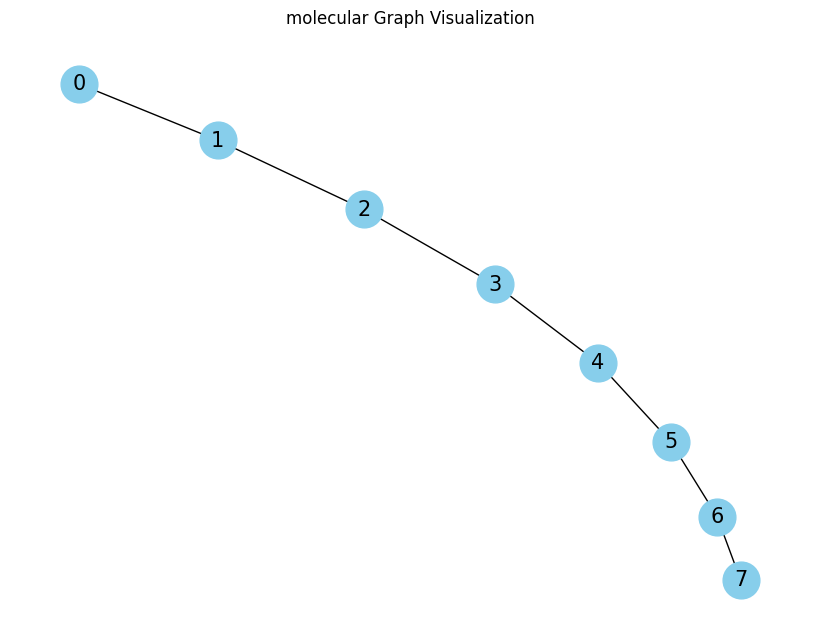

In [32]:
plt.figure(figsize=(8, 6))  # 그래프 크기 설정
nx.draw(molGraph, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=15)
plt.title("molecular Graph Visualization")
plt.show()

In [16]:
# 분자 예시
mol = Chem.MolFromSmiles('CCOCCOCC')  # 에탄올 예시 분자

# get_fragments 함수로부터 프래그먼트(클릭) 추출
cliques, edges = get_fragments(mol)

In [22]:
G = create_fragment_graph(cliques, edges)

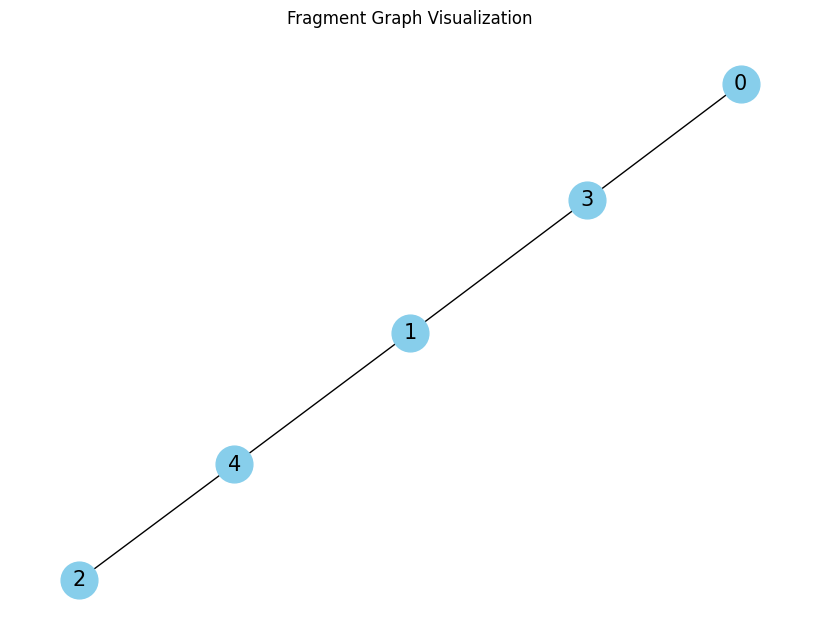

In [28]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(8, 6))  # 그래프 크기 설정
nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=15)
plt.title("Fragment Graph Visualization")
plt.show()

In [29]:
def delete_node_fragment(G, node, cliques):
    """
    주어진 노드(원자)가 속한 프래그먼트를 찾아 해당 프래그먼트를 삭제합니다.
    
    Parameters:
    - G: nx.Graph 객체, 분자의 원자 그래프
    - node: int, 삭제할 원d자의 인덱스
    - cliques: list of lists, 분자의 프래그먼트 정보
    
    Returns:
    - G: 업데이트된 nx.Graph 객체
    """
    
    # 주어진 노드(원자)가 속한 프래그먼트 찾기
    fragment_to_delete = None
    for clique in cliques:
        if node in clique:
            fragment_to_delete = clique
            break
    
    if fragment_to_delete is None:
        print("노드가 속한 프래그먼트를 찾을 수 없습니다.")
        return G
    
    # 프래그먼트에 속한 모든 노드(원자)를 그래프에서 삭제
    for node in fragment_to_delete:
        if G.has_node(node):
            G.remove_node(node)
    
    return G

In [13]:
fragment_graph

defaultdict(set, {0: {3}, 3: {0, 1}, 1: {3, 4}, 4: {1, 2}, 2: {4}})

In [37]:
from util import get_fragments


In [38]:
frag_indices, _ = get_fragments(mol)

In [39]:
frag_indices

[[0, 1, 2, 9, 10], [3, 4, 5, 6, 7, 8], [16, 11, 12, 13, 14, 15]]

In [40]:
import numpy as np

def find_center_fragment(center, frag_indices):
    """
    Center 노드가 속한 프래그먼트를 찾아서 반환합니다.
    """
    for frag in frag_indices:
        if center in frag:
            return frag
    return []

In [184]:
def map_fragment_adjacency(mol, frag_indices):
    """
    Maps fragment adjacency based on molecular bonds.
    Returns a dict where keys are fragment indices and values are sets of adjacent fragment indices.
    """
    adjacency_map = {i: set() for i in range(len(frag_indices))}
    for bond in mol.GetBonds():
        a1, a2 = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        for i, frag1 in enumerate(frag_indices):
            if a1 in frag1:
                for j, frag2 in enumerate(frag_indices):
                    if a2 in frag2 and i != j:
                        adjacency_map[i].add(j)
                        adjacency_map[j].add(i)
    return adjacency_map

def remove_adjacent_fragments(Graph, center_frag_idx, frag_indices, adjacency_map, percent=0.2):
    G = Graph.copy()
    num = int(np.floor(len(G.nodes) * percent))
    
    removed_nodes = []
    visited_frags = set()  # Set of visited fragments
    
    # First, unconditionally remove the fragment containing the center node
    initial_frag = frag_indices[center_frag_idx]
    for node in initial_frag:
        if node in G:
            G.remove_node(node)
            removed_nodes.append(node)
    visited_frags.add(center_frag_idx)

    # Initialize the queue with adjacent fragments of the initial fragment
    frags_to_remove = [adj_frag for adj_frag in adjacency_map[center_frag_idx] if adj_frag not in visited_frags]

    # Conditionally remove additional fragments, considering the 'num' limit
    while frags_to_remove and len(removed_nodes) < num:
        current_frag_idx = frags_to_remove.pop(0)
        if current_frag_idx in visited_frags:
            continue
        
        current_frag = frag_indices[current_frag_idx]
        # Check if adding this fragment exceeds the 'num' limit
        if len(removed_nodes) + len(current_frag) > num:
            continue  # Skip this fragment if it would exceed the limit
        
        for node in current_frag:
            if node in G:
                G.remove_node(node)
                removed_nodes.append(node)
        
        visited_frags.add(current_frag_idx)
        
        # Add unvisited adjacent fragments to the queue
        for adjacent_frag_idx in adjacency_map[current_frag_idx]:
            if adjacent_frag_idx not in visited_frags:
                frags_to_remove.append(adjacent_frag_idx)
    
    removed_edges = [(u, v) for u, v in Graph.edges() if u in removed_nodes or v in removed_nodes]

    return removed_nodes, removed_edges

# Assuming you have the molecule (mol) and the graph (G) ready, along with frag_indices
center = 0  # Example center node
center_frag_idx = next(i for i, frag in enumerate(frag_indices) if center in frag)  # Find center fragment index
adjacency_map = map_fragment_adjacency(mol, frag_indices)  # Map fragment adjacency

In [185]:
mol = Chem.MolFromSmiles('C1CC(C2=CC=CC=C2)CC1C3=CC=CC=C3')  # Example molecule
bonds = mol.GetBonds()

edges = []
for bond in bonds:
    edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
molGraph = nx.Graph(edges)

In [186]:
# Remove fragments and their adjacent fragments based on the mapped adjacency and target percent
removed_nodes, removed_edges = remove_adjacent_fragments(molGraph, center_frag_idx, frag_indices, adjacency_map, percent=0.2)

In [187]:
frag_indices

[[0, 1, 2, 9, 10], [3, 4, 5, 6, 7, 8], [16, 11, 12, 13, 14, 15]]

In [188]:
removed_nodes

[0, 1, 2, 9, 10]

In [189]:
removed_edges

[(0, 1), (0, 10), (1, 2), (2, 3), (2, 9), (9, 10), (10, 11)]

In [161]:
removed_nodes

[0, 1, 2, 9, 10, 3, 4, 5, 6, 7, 8]

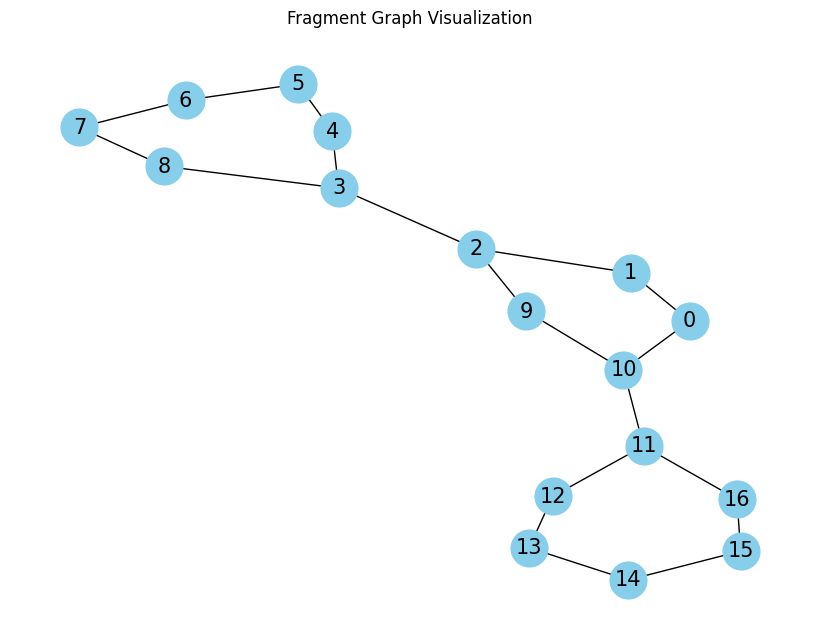

In [132]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(8, 6))  # 그래프 크기 설정
nx.draw(molGraph, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=15)
plt.title("Fragment Graph Visualization")
plt.show()

In [124]:
len(molGraph.nodes)

8

In [92]:
frag_indices

[[0, 1, 2, 9, 10], [3, 4, 5, 6, 7, 8], [16, 11, 12, 13, 14, 15]]

In [107]:
removed_nodes

[0, 1, 2, 3, 4, 5, 6, 7]

In [85]:
adjacency_map

{0: {1, 2}, 1: {0}, 2: {0}}

In [73]:
G.nodes()

NodeView(())

In [79]:
removed_nodes

[]

In [75]:
removed_edges

[]